In [98]:
import torch
import torchvision
import os
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from tqdm import tqdm
from collections import Counter
import random
import csv
import pandas as pd
from torchsummary import summary

In [99]:
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_files_list = [s for s in os.listdir(img_dir)]
        self.transform = transforms.Compose([
                                                transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                           ])
        self.label_transform = transforms.ToTensor()
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_files_list[idx])
        image = Image.open(img_name)
#         image = self.transform(image)
        label = int(self.img_files_list[idx].split("_")[0])
        sample = {"image": image, "label": label}
        return image, label
    
    def __len__(self):
        return len(self.img_files_list)
    
    def transform(self, transform):
        self.transform = transform

class CSVDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)#有不同
        self.targets = self.img_labels.iloc[:, 1]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.img_labels)

In [100]:
train_transform = transforms.Compose([
                                        # transforms.RandomResizedCrop(224),
                                        # transforms.CenterCrop(512),
                                        transforms.Resize([224, 224]),
                                        #transforms.RandomResizedCrop(448),
                                        # transforms.Resize(256),
                                        # transforms.CenterCrop(224),
                                        # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                                        # transforms.Randomapply([transforms.Colorjitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0)], p=0.5)
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

test_transform = transforms.Compose([
                                        transforms.Resize(256),
                                        #transforms.Resize([512, 512]),
                                        #transforms.CenterCrop(448),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

In [109]:
# Load the images to Self defined Dataset
train_set = CSVDataset('严格9比1分train.csv', '严格9比1分train', train_transform)
test_set = CSVDataset('严格9比1分test.csv','严格9比1分test' , test_transform)
#print(train_set.targets)
# Weighted Random Sampler for imbalanced dataset
class_weights = [1/i for i in dict(Counter(train_set.targets)).values()]
weights = [class_weights[int(i)] for i in train_set.targets]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=5, pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=5, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=5, pin_memory=False)
dataset_sizes = {'train': len(train_set), 'test': len(test_set)}
dataloaders = {'train': train_loader, 'test': test_loader}
print(dataset_sizes, dataloaders)

{'train': 15430, 'test': 1708} {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f597b75eb70>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f597b75eac8>}


In [110]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1,'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
torch.cuda.set_device(0)
print(torch.cuda.current_device())
# if output_device is None:
#     output_device =device_ids[1]

cuda:0
0


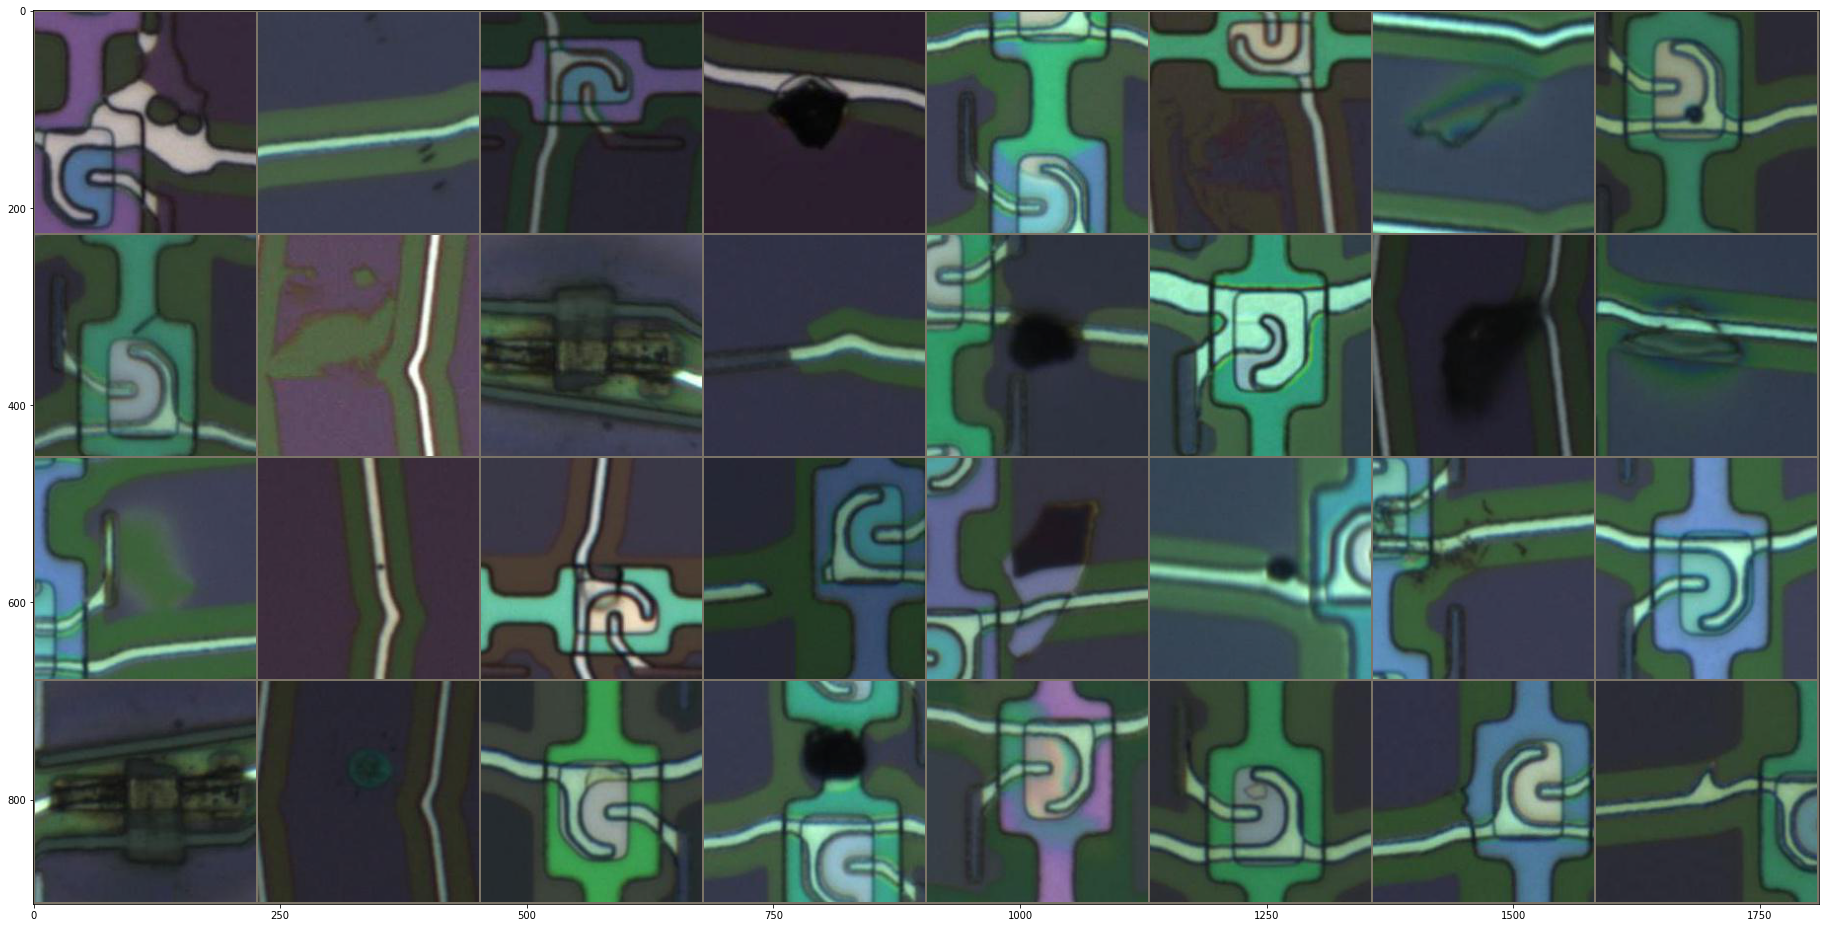

In [111]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (32,32))
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    
    
#     plt.pause(0.001)  # pause a bit so that plots are updated
    
    plt.savefig('imshow_A_RRC224.png')


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[int(x) for x in classes])

In [112]:
def draw_loss(loss_metrics, acc_metrics, last):
    xx = range(0, len(loss_metrics['train']))
    
    ax1 = plt.subplot(1, 2, 1)
    plt.sca(ax1)
    plt.plot(xx, loss_metrics['train'], "r", label="train_loss")
    plt.plot(xx, loss_metrics['test'], "b", label="valid_loss")
    plt.legend()
    
    ax2 = plt.subplot(1, 2, 2)
    plt.sca(ax2)
    plt.plot(xx, acc_metrics['train'], "y", label="train_acc")
    plt.plot(xx, acc_metrics['test'], "g", label="valid_acc")
    plt.legend()
    
    #if last:
        #plt.savefig('./AUO_Joint_training/35/Images/Metric_Incrementl_ResNet18_Adam_lr_1e-3_balanced.png')
        
    plt.show()

In [113]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    loss_metrics = {}
    acc_metrics = {}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print("-" * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0#有不同
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
#                     if phase == 'train':
#                         outputs, aux_logits2, aux_logits1 = model(inputs)
#                     else:
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
#                     print(outputs)
#                     if phase == 'train':
#                         loss = criterion(outputs, labels)
#                         loss += criterion(aux_logits1, labels) * 0.3
#                         loss += criterion(aux_logits2, labels) * 0.3
#                     else:
                    loss = criterion(outputs, labels)
                    
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase not in loss_metrics:
                loss_metrics[phase] = list()
            loss_metrics[phase].append(epoch_loss)
            
            if phase not in acc_metrics:
                acc_metrics[phase] = list()
            acc_metrics[phase].append(epoch_acc.cpu())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
        if epoch == num_epochs-1:
            last = True
        else:
            last = False
            
        draw_loss(loss_metrics, acc_metrics, last)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, loss_metrics, acc_metrics

In [114]:
num_classes = 34
epochs = 150
# model_ft = torchvision.models.googlenet(num_classes = num_classes, aux_logits=True, init_weights=True, pretrained=False)
# model_ft = torchvision.models.efficientnet_b4(pretrained=True)
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# num_ftrs = model_ft.classifier[1].in_features

# print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)
# model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3, weight_decay=0.0005)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
# torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, epochs)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [115]:
# print(model_ft.fc.in_features)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [108]:
summary(model_ft, (3, 224, 224))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
model_ft, loss_metrics, acc_metrics = train(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/149
----------


100%|██████████| 121/121 [01:11<00:00,  1.70it/s]


train Loss: 1.9418 Acc: 0.4627


  0%|          | 0/14 [00:00<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sally/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/sally/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sally/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-9-ddc434faa1ae>", line 36, in __getitem__
    image = Image.open(img_path)
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 2975, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '.old_data/严格9比1分test/D00L09_M2-Crack_PV9_b0.7_hori0H13U30-01_26_NGID026500019_cropped_1.jpg'


In [14]:
torch.save(model_ft.state_dict(), './ysq_resnet18.pt')

In [13]:
def confusion_matrix(model, class_num, dataloader):
    cmt = torch.zeros(class_num, class_num, dtype=torch.int64)
    targets = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:

            model.to(device)
            
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            _, preds = torch.max(output, 1)
            
            
            preds = preds.data.cpu().numpy()
            labels = labels.data.cpu().numpy()
            
#             print(preds)
    
            targets = np.concatenate((targets, labels), axis = 0)
            all_preds = np.concatenate((all_preds, preds), axis = 0)
            
#             print(targets)
#         stacked = torch.stack((targets, all_preds.argmax(dim=1)), dim=1)
            stacked = np.stack((targets, all_preds), axis=1).astype(int)
#             print(stacked)

        for p in stacked:
            tl, pl = p.tolist()
            cmt[tl, pl] = cmt[tl, pl] + 1
    return cmt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm.shape)
    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in (range(cm.shape[0])):
        for j in (range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("./学长测试2.png")

In [14]:
cmt = confusion_matrix(model_ft, num_classes, dataloaders['test'])

Confusion matrix, without normalization
torch.Size([34, 34])


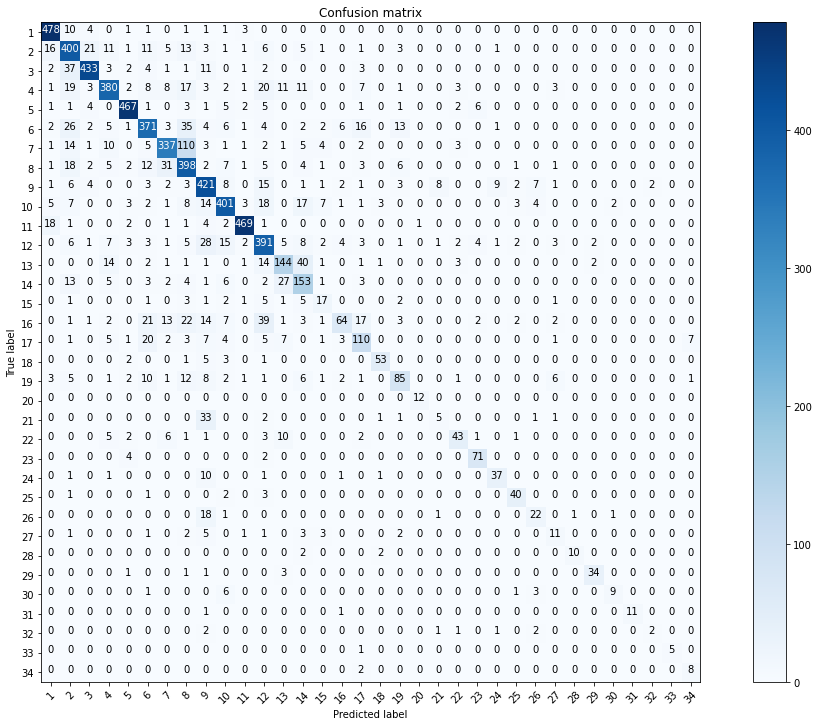

In [20]:
classes = np.arange(1, num_classes+1)
a = np.arange(1, num_classes+1)
plot_confusion_matrix(cmt, a)

In [15]:
def test(model, criterion):
    since = time.time()
    
    model.eval()

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
            
    running_loss = 0.0
    running_corrects = 0
            
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
                

        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)                        

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']
            
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))
            
        
    time_elapsed = time.time() - since

    return predlist, lbllist

In [16]:
# if needed to laod the models
num_classes = 33
model_test = torchvision.models.resnet18(pretrained=False)

num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, num_classes)
model_test = model_test.to(device)
criterion = nn.CrossEntropyLoss()

model_test.load_state_dict(torch.load('./學長測試.pt'))

<All keys matched successfully>

In [17]:
p, t = test(model_test, criterion)

100%|██████████| 26/26 [00:23<00:00,  1.11it/s]

test Loss: 0.1890 Acc: 0.9508


In [18]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(t, p)

avg_p = sum(precision) / len(precision)
avg_r = sum(recall) / len(recall)
avg_f = sum(fscore) / len(fscore)
avg_s = sum(support)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.96830266 0.73425197 0.85114504 0.77281947 0.94020619 0.798627
 0.78367347 0.69837587 0.7989418  0.82309582 0.49315068 0.7244898
 0.71698113 0.27522936 0.36666667 0.5        0.55319149 0.77289377
 0.81012658 0.28846154 0.66350711 0.56028369 0.53947368 0.52466368
 0.77027027 0.09821429 0.58461538 0.23913043 0.58823529 0.85
 0.6        0.36363636 0.        ]
recall: [0.93669634 0.746      0.892      0.762      0.912      0.698
 0.75294118 0.602      0.604      0.67       0.72483221 0.92207792
 0.80851064 0.68181818 0.84615385 0.66666667 0.69333333 0.81153846
 0.73846154 0.375      0.61946903 0.71818182 0.57209302 0.66101695
 0.87692308 0.25       0.73076923 0.36666667 0.71428571 0.85
 0.33333333 0.4        0.        ]
fscore: [0.95223731 0.74007937 0.87109375 0.7673716  0.92588832 0.74493063
 0.768      0.64661654 0.68792711 0.73869901 0.58695652 0.81142857
 0.76       0.39215686 0.51162791 0.57142857 0.61538462 0.79174484
 0.77263581 0.32608696 0.64073227 0.62948207 0.55530

In [2]:
fscore=[0.95223731 ,0.74007937, 0.87109375, 0.7673716,  0.92588832, 0.74493063,
 0.768, 0.64661654, 0.68792711, 0.73869901, 0.58695652, 0.81142857,
 0.76 , 0.39215686, 0.51162791, 0.57142857, 0.61538462, 0.79174484,
 0.77263581, 0.32608696, 0.64073227 ,0.62948207, 0.55530474 ,0.585,
 0.82014388 ,0.14102564, 0.64957265, 0.28947368, 0.64516129 ,0.85,
 0.42857143 ,0.38095238, 0.        ]
ans=sum(fscore)/len(fscore)
print(ans)

0.6241731615151516


In [19]:
import csv
with open("./AUO_Joint_training/35/Metrics/Incremental_ResNet18_Adam_lr_1e-3_balanced.csv", mode='w') as file:
    writer = csv.writer(file, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['precision', 'recall', 'fscore', 'support'])
    
    for i in range(len(precision)):
        writer.writerow([precision[i], recall[i], fscore[i], support[i]])
    
    writer.writerow([avg_p, avg_r, avg_f, avg_s])